In [1]:
# May need to uncomment and run if tensorflow not installed in Jupyter
import sys
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install matplotlib

data_dir: xtx
corpus_dir: corpus
> 1. build_and_save_corpus from: xtx to corpus
> extract_headings_from_files
> extract_headings_from_file
tokenize_heading: |<generator object tokenize_heading.<locals>.<genexpr> at 0x000001576F445A98>|
headings_list of 10
['access_control_systems', 'accounting_degree_programs', 'adoption_foster_care', 'adult_literacy_ged', 'literacy_ged_resources', 'after_school_programs', 'aids_hiv_specialists', 'air_space_museums', 'air_charters_transportation', 'air_duct_cleaning']
< extract_headings_from_file (1.csv) Lines: 2122
> extract_headings_from_file
headings_list of 10
['accountants_certified_public', 'accounting_bookkeeping_services', 'adhesives_gluing_equipment', 'adult_care_facilities', 'advertising_directory_guide', 'advertising_direct_mail', 'advertising_electronic_fax', 'advertising_promotional_products', 'promotional_products_services', 'aerospace_industries_services']
< extract_headings_from_file (2.csv) Lines: 2918
> extract_headings_from_file
head

C:\Users\User\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:188: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


< 2. train_and_save_model
> 3. explore_model
access_control_systems
after_school_programs
aircraft_equipment_parts
equipment_parts_supplies
aircraft_service_maintenance
armored_car_services
art_galleries_dealers
audio_visual_equipment
auto_air_conditioning
auto_body_repair
Target: access_control_systems
Vector:
|[-0.00137705 -0.00161637 -0.00118251 -0.0017462  -0.00035981 -0.00025389
  0.00149228  0.00018018 -0.00072893  0.0001974  -0.00022594  0.00004871
 -0.00040014 -0.00098549 -0.00039508 -0.00037537  0.00023673  0.00219131
 -0.0019531  -0.00166365  0.00109726 -0.00132466  0.00238184  0.00155894
  0.00218552  0.0028083   0.00146639  0.0014204   0.00207472 -0.00097059
  0.00213093  0.00115073  0.00135566 -0.00031477 -0.00183385  0.0012177
  0.00174105  0.00150456  0.00242607  0.00156244  0.00059101 -0.00066041
  0.0016168   0.0024526   0.00175132  0.0013546   0.00234919  0.00013023
 -0.0005384  -0.00256055 -0.00276562 -0.00014137 -0.00190796 -0.00295152
  0.0005687  -0.00088414  0.00

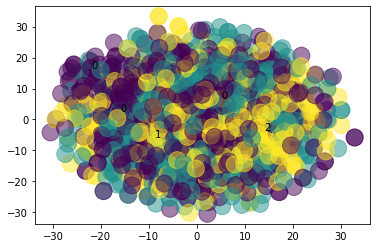

  < done.
< 5. explore_sklearn_clustering
< 4. explore_clustering


In [3]:
#!/usr/bin/env python
"""
Yputer explores the Yellow Pages Heading Space

Yputer uses Word2Vec to transform Yellow Pages headings into a set of
vectors that can then be analyzed through a variety of technologies, 
specifically K-Means clustering.  Major Steps are

    Build and Save the Corpus from initial set of CSV files
    Train and Save the Model of word vectors
    Explore the Model in a stand-alone manner
    Explore Clustering applied to the model.

The code is organized as a set of Utility Functions and Major Functions.

History

5 Nov 19.  Michael Bauer created the initial Jupyter Notebook using only
single word terms to create the initial model.  Once created, the model 
is then explored using Word2Vec tools.  Then K-Means clustering is applied
and the results plotted.
"""
# Packages
import os
import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import logging
import tensorflow as tf
import numpy as np
import collections
from collections import Counter
import re
from sklearn import cluster
from sklearn import metrics
from nltk.cluster import KMeansClusterer
import nltk
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from nltk import ngrams

# Logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Globals

data_directory = 'xtx'
model_directory = 'models'
model_filename = 'model.txt'
corpus_directory = 'corpus'
corpus_filename = 'corpus.txt'
terms_filename = 'terms.txt'

just_looking = True
really_just_looking = True

the_model = None
the_corpus = None

# UTILITY FUNCTIONS

# Normalization Functions

def clean_heading(heading):
    cleaned_heading = heading
    cleaned_heading = cleaned_heading.lower().strip()
    cleaned_heading = re.sub(r'[^a-z0-9\s]', '', cleaned_heading)
    cleaned_heading = re.sub(r'\s{2,}', ' ', cleaned_heading)

    return cleaned_heading

def tokenize_heading(heading):
    global just_looking
#     print(f'HELLO {heading}')
    n = 3
    bigrams = ngrams(heading.split(), n)
    bigram_list =[]
    for grams in bigrams:
        if len(heading) < 3:
            pass
        else:
            bigram_list.append(grams)
    tokenized_heading = ('_'.join(w) for w in bigram_list)
    if just_looking:
        print("tokenize_heading: |%s|" % (tokenized_heading))
        just_looking = False
    return tokenized_heading   

# Extraction Functions

def extract_heading_from_line(line):
    cleaned_heading = clean_heading(line)
    tokenized_heading = tokenize_heading(cleaned_heading)
    
    return tokenized_heading

def extract_headings_from_file(root, filename):
    parsed_heading = None
    global really_just_looking
    
    parsed_headings = []
    header_line_accounted_for = False
    filepath = os.path.join(root, filename)
    
    print("> extract_headings_from_file")    
    with open(filepath, 'r') as file:
        for index, line in enumerate(file):
            if header_line_accounted_for:
                parsed_heading = extract_heading_from_line(line)
#                 print(f'HELLO {parsed_heading}')
                parsed_headings.append(parsed_heading)
            else:
                header_line_accounted_for = True

    headings_list = [a for b in parsed_headings for a in b] 
    print('headings_list of 10')
    print(headings_list[:10])
    
    print("< extract_headings_from_file (%s) Lines: %d" % (filename,index))
    return headings_list

def extract_headings_from_files(directory):
    parsed_headings = []
    number_files_processed = 0
    
    print("> extract_headings_from_files")
    for root,dirs,filenames in os.walk(directory):
        filenames.sort()
        for filename in filenames:
            if filename.endswith(".csv"):
                parsed_headings.append(extract_headings_from_file(root, filename))
                number_files_processed += 1     
            else:
                print('! Skipping %s - not a csv file.' % (filename))
    print("< extract_headings_from_files - Files: %d" % (number_files_processed))
    return parsed_headings

# MAJOR FUNCTIONS
# 

def build_and_save_corpus(data_directory,corpus_directory,corpus_filename):
    print(f'data_dir: {data_directory}')
    print(f'corpus_dir: {corpus_directory}')
    corpus = None
    words = None

    print("> 1. build_and_save_corpus from: %s to %s" % (data_directory,corpus_directory))   
    
    # Currently not saving corpus.
    # corpus_filepath = os.path.join(corpus_directory, corpus_filename) 
    
    words = extract_headings_from_files(data_directory)
    corpus = words
    
    print("< 1. build_and_save_corpus")
    return corpus

def train_and_save_model(corpus,model_directory,model_filename):
    model = None
    print("> 2. train_and_save_model")   
    
    model_filepath = os.path.join(model_directory, model_filename) 
    model = Word2Vec(corpus, size=150, window=3, min_count=4)
    model.save(model_filepath)    
    
    print("< 2. train_and_save_model")
    return model

def explore_model(model):
    print("> 3. explore_model")   
    for i, word in enumerate(model.wv.vocab):
        if i == 10:
            break
        print(word)

    target = 'access_control_systems'
    vectors = model.wv    
    vector = vectors.word_vec(target)
    similar = model.wv.most_similar(positive=[target])
    print("Target: %s" % target)
    print("Vector:\n|%s|" % vector)
    print("Similar:\n|%s|" % similar)
    print("< 3. explore_model")   

def explore_sklearn_clustering(model, corpus):
    print("> 5. explore_sklearn_clustering") 
    NUM_CLUSTERS=3
    X = model[model.wv.vocab]

    kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
    kmeans.fit(X)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
 
    print ("Cluster id labels for inputted data")
    print (labels)
    print ("Centroids data")
    print (centroids)

    print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
    print (kmeans.score(X))

    silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')

    print ("Silhouette_score: ")
    print (silhouette_score)


    # Plot
    print("  > Generating Plot...")
    kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=10)
    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)    
    tsne_model = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y=tsne_model.fit_transform(X) 
    plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5)
    for j in range(len(corpus)):    
       plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
#        print ("%s %s" % (assigned_clusters[j],  corpus[j]))
    plt.show()
    print("  < done.")    
    print("< 5. explore_sklearn_clustering")   

     
def explore_clustering(model, corpus):
    print("> 4. explore_clustering")
    explore_sklearn_clustering(model, corpus)
    print("< 4. explore_clustering") 
    
# MAIN
#

the_corpus = build_and_save_corpus(data_directory,corpus_directory,corpus_filename)
the_model = train_and_save_model(the_corpus,model_directory,model_filename)
explore_model(the_model)
explore_clustering(the_model, the_corpus)

# END 

# Commentary on ignoring terms that fall short of the total number required.

By ignoring terms that fall short of the total number required, the silhouette score drops, meaning the degree of similarity of a point to its cluster versus the next closest cluster has dropped. I believe that including such terms would improve the silhouette score, and improve the accuracy of the clustering. By exluding these terms, it makes the vocabulary of the text in question (Yellow Pages) more sparse and generally makes the training data set smaller; when you have a data set with lower text frequency and/or a small data set, it is wiser to use a lower-order n-gram model. In this case, ignoring terms that fall short of the total number required, while simultaneously increasing the order of the n-gram model leads to an inferior model. Including these terms would in theory make using a higher order n-gram model more reasonable, as it help maintain a larger data set with a rich text vocabulary. It would be difficult to do, but to include the terms that fall short of the total number required, the terms could be combined with the its nearest neighbor to create terms that are long enough to be included in the n-gram model. These terms would be similar in some cases due to the fact that they are in alphabetical order, but this would not hold true for all cases, and the impact of this would need to be closely investigated. 

